In [3]:
import sklearn
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from collections import namedtuple

In [4]:
root = Path().absolute().parent.parent
dataset_path = root.joinpath('res', 'all_raw.csv')

df = pd.read_csv(dataset_path)
df.keys()

Index(['Unnamed: 0', 'Date', 'deaths', 'confirmed', 'recovered', 'active',
       'new_confirmed', 'new_recovered', 'new_deaths', 'Unnamed: 0.1',
       ...
       'Vita', 'bitrate', 'Weekly_average_change_views',
       'Weekly_average_views', 'Users', 'In-Game', 'av_conc_viewers',
       'av_conc_channels', 'time_watched', 'active_streamers'],
      dtype='object', length=118)

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('Unnamed: 0.1', axis=1, inplace=True)
df['Date'] = df['Date'].apply(lambda x : x[:-15])  # Drop the UTC string part.

In [6]:
end_date = '2020-01-01'
end_index = df.index[(df['Date'] == end_date).values][0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1277 entries, 0 to 1276
Columns: 116 entries, Date to active_streamers
dtypes: float64(115), object(1)
memory usage: 1.1+ MB


[]

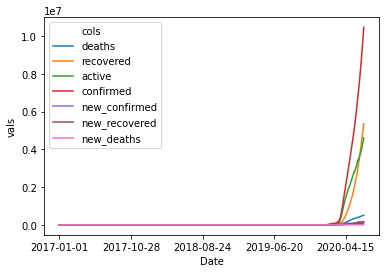

In [7]:
# Corona processing. Extend data to earliest date. Plot to verify.

df['deaths'].fillna(0, inplace=True)
df['recovered'].fillna(0, inplace=True)
df['active'].fillna(0, inplace=True)
df['confirmed'].fillna(0, inplace=True)
df['new_confirmed'].fillna(0, inplace=True)
df['new_recovered'].fillna(0, inplace=True)
df['new_deaths'].fillna(0, inplace=True)

covid_df = df.melt('Date', value_vars= ['deaths', 'recovered', 'active', 'confirmed', 'new_confirmed', 'new_recovered', 
                                        'new_deaths'], 
                   var_name='cols',  value_name='vals')
g = sns.lineplot(x="Date", y="vals", hue='cols', data=covid_df)
g.set_xticks(np.arange(0, len(df['Date']), 300))
g.plot()

[]

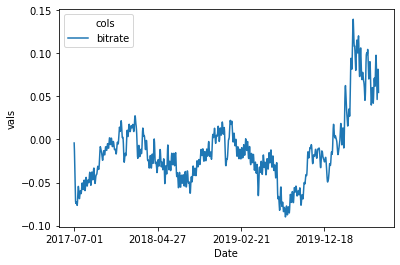

In [8]:
# IX Data inspection.
df['bitrate'] = df['bitrate'].rolling(7, win_type='triang', min_periods=1).sum()
ix_df = df.melt('Date', value_vars= ['bitrate'], 
                   var_name='cols',  value_name='vals')

g = sns.lineplot(x="Date", y="vals", hue='cols', data=ix_df)
g.set_xticks([0,300, 600, 900])
g.plot()

[]

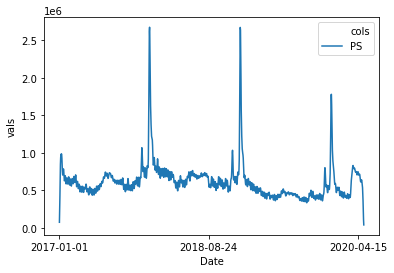

In [9]:
# Playstation data processing. Reduce to a single data series by summation over the PSN. Employ moving average?
if 'PS3' in df.keys():
    df['PS'] = df['PS3'] + df['PS4'] + df['Vita']
    df.drop('PS3', axis=1, inplace=True)
    df.drop('PS4', axis=1, inplace=True)
    df.drop('Vita', axis=1, inplace=True)

ps_df = df.melt('Date', value_vars= ['PS'], 
                   var_name='cols',  value_name='vals')

# Smooth time series with rolling average.
ps_df['vals'] = ps_df['vals'].rolling(7, win_type='triang', min_periods=1).sum()


g = sns.lineplot(x="Date", y="vals", hue='cols', data=ps_df)
g.set_xticks([0,600,1200])
g.plot()

[]

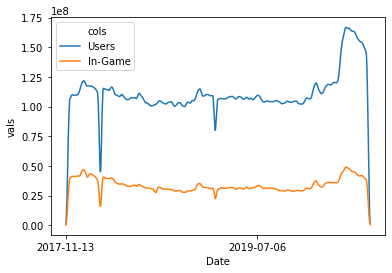

In [10]:
# Steam processing.
steam_df = df[['Date', 'Users', 'In-Game']].copy()

steam_df['Users'] = steam_df['Users'].rolling(14, win_type='triang', min_periods=1).sum()
steam_df['In-Game'] = steam_df['In-Game'].rolling(14, win_type='triang', min_periods=1).sum()

steam_df = steam_df.melt('Date', value_vars= ['Users', 'In-Game'], 
                   var_name='cols',  value_name='vals')

g = sns.lineplot(x="Date", y="vals", hue='cols', data=steam_df)
g.set_xticks([0,600,1200])
g.plot()

Total NaN Values left: 29


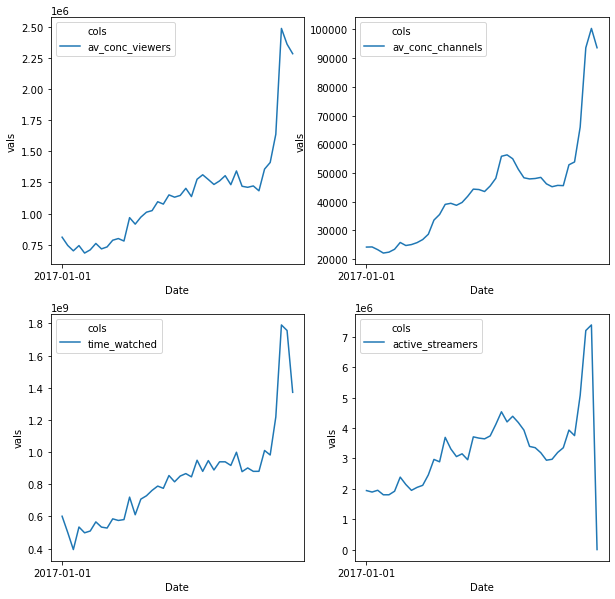

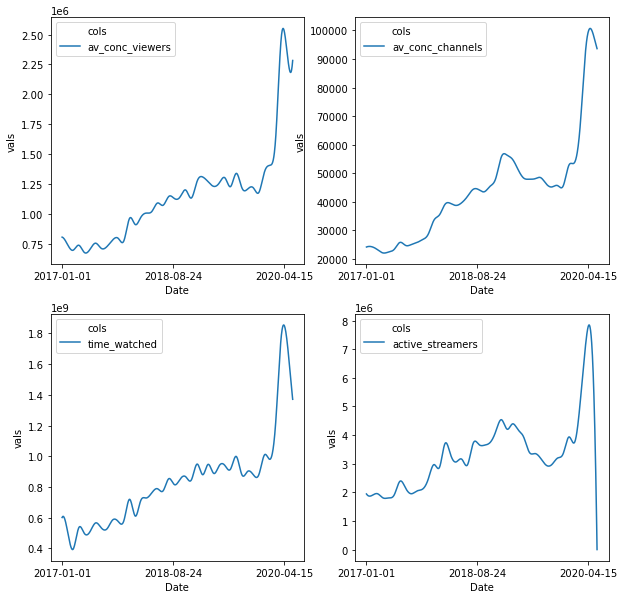

In [11]:
# Twitch processing. Visualize default data first. Seperate plots because of the different scales before scaling.

fig0, axes0 = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(10,10))

twitch_0 = df.melt('Date', value_vars= ['av_conc_viewers'], 
                   var_name='cols',  value_name='vals')
twitch_1 = df.melt('Date', value_vars= ['av_conc_channels'], 
                   var_name='cols',  value_name='vals')
twitch_2 = df.melt('Date', value_vars= ['time_watched'], 
                   var_name='cols',  value_name='vals')
twitch_3 = df.melt('Date', value_vars= ['active_streamers'], 
                   var_name='cols',  value_name='vals')

g0 = sns.lineplot(x="Date", y="vals", hue='cols', data=twitch_0, ax=axes0[0, 0])
g1 = sns.lineplot(x="Date", y="vals", hue='cols', data=twitch_1, ax=axes0[0, 1])
g2 = sns.lineplot(x="Date", y="vals", hue='cols', data=twitch_2, ax=axes0[1, 0])
g3 = sns.lineplot(x="Date", y="vals", hue='cols', data=twitch_3, ax=axes0[1, 1])
g0.set_xticks([0,600,1200])
g1.set_xticks([0,600,1200])
g2.set_xticks([0,600,1200])
g3.set_xticks([0,600,1200])
g0.plot()
g1.plot()
g2.plot()
g3.plot()


# Linear interpolation because net operates on daily data.
df['av_conc_viewers'].interpolate(method='polynomial', order=3, inplace=True)
df['av_conc_channels'].interpolate(method='polynomial', order=3, inplace=True)
df['time_watched'].interpolate(method='polynomial', order=3, inplace=True)
df['active_streamers'].interpolate(method='polynomial', order=3, inplace=True)

# Visualize.
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(10,10))

twitch_0 = df.melt('Date', value_vars= ['av_conc_viewers'], 
                   var_name='cols',  value_name='vals')
twitch_1 = df.melt('Date', value_vars= ['av_conc_channels'], 
                   var_name='cols',  value_name='vals')
twitch_2 = df.melt('Date', value_vars= ['time_watched'], 
                   var_name='cols',  value_name='vals')
twitch_3 = df.melt('Date', value_vars= ['active_streamers'], 
                   var_name='cols',  value_name='vals')

g0 = sns.lineplot(x="Date", y="vals", hue='cols', data=twitch_0, ax=axes[0, 0])
g1 = sns.lineplot(x="Date", y="vals", hue='cols', data=twitch_1, ax=axes[0, 1])
g2 = sns.lineplot(x="Date", y="vals", hue='cols', data=twitch_2, ax=axes[1, 0])
g3 = sns.lineplot(x="Date", y="vals", hue='cols', data=twitch_3, ax=axes[1, 1])
g0.set_xticks([0,600,1200])
g1.set_xticks([0,600,1200])
g2.set_xticks([0,600,1200])
g3.set_xticks([0,600,1200])
g0.plot()
g1.plot()
g2.plot()
g3.plot()

print('Total NaN Values left: {}'.format(df['time_watched'].isna().sum()))

[]

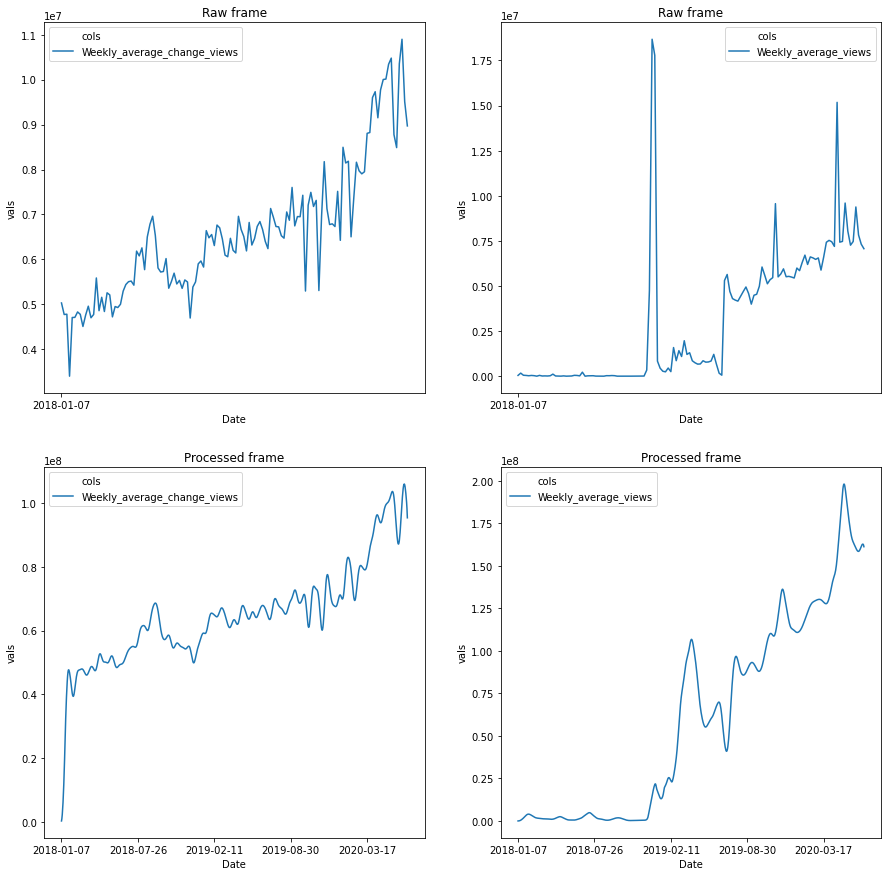

In [12]:
# Socialblade processing.
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(15,15))

sb_00 = df.melt('Date', value_vars= ['Weekly_average_change_views'], 
                   var_name='cols',  value_name='vals')
sb_01 = sb_00.copy(deep=True)
sb_01['vals'] = sb_01['vals'].interpolate(method='polynomial', order=3)
sb_01['vals'] = sb_01['vals'].rolling(20, win_type='triang', min_periods=1).sum()

sb_10 = df.melt('Date', value_vars= ['Weekly_average_views'], 
                   var_name='cols',  value_name='vals')
sb_11 = sb_10.copy(deep=True)
sb_11['vals'] = sb_10['vals'].interpolate(method='polynomial', order=3)
mask = np.arange(0,len(sb_11.vals))
mask = mask < 905
sb_11.loc[mask, 'vals'] = np.where(sb_11.loc[mask, 'vals'] > 3000000,0, sb_11.loc[mask, 'vals'])
sb_11.loc[:, 'vals'] = np.where(sb_11.loc[:, 'vals'] < 0,0, sb_11.loc[:, 'vals'])

sb_11.loc[mask, 'vals'] = sb_11.loc[mask, 'vals'].to_numpy() * np.linspace(1,4,905)

sb_11['vals'] = sb_11['vals'].rolling(40, win_type='triang', min_periods=1).sum()

# Write to the original dataset.
df['Weekly_average_change_views'] = sb_01['vals']
df['Weekly_average_views'] = sb_11['vals']

# Plot for inspection.
g0 = sns.lineplot(x="Date", y="vals", hue='cols', data=sb_00, ax=axes[0,0])
g1 = sns.lineplot(x="Date", y="vals", hue='cols', data=sb_10, ax=axes[0,1])
g2 = sns.lineplot(x="Date", y="vals", hue='cols', data=sb_01, ax=axes[1,0])
g3 = sns.lineplot(x="Date", y="vals", hue='cols', data=sb_11, ax=axes[1,1])

g0.set_xticks(np.arange(0,801,200))
g0.set_title('Raw frame')
g1.set_xticks(np.arange(0,801,200))
g1.set_title('Raw frame')
g2.set_xticks(np.arange(0,801,200))
g2.set_title('Processed frame')
g3.set_xticks(np.arange(0,801,200))
g3.set_title('Processed frame')

g0.plot()
g1.plot()
g2.plot()
g3.plot()

In [13]:
med_codes = ['EVT', 'SHL', 'BAS', 'BAYN', 'FMS', 'FRE.DE', 'JNJ', 'PFE', 'ABT',
             'KMB', 'MDT', 'PHG', 'GE', 'BDX', 'CAH', 'SYK']
bank_codes = ['DB', 'ICK', 'GS', 'CMC', 'BRYN', 'NCB', 'WFC', 'JPHLF', 'CICHY',
              'ACGBY', 'CRARY', 'BACHF', 'C']
energy_codes = ['SIEGY', 'EOAN.DE', 'RWE.DE', 'DUK', 'ENGI.PA', 'NGG', 'NEE',
                'EDF']
oil_codes = ['CVX', 'XOM', 'PTR', 'RDS-A', 'LUK', 'ROSN', 'TOT', 'BP', 'SNP']
steel_codes = ['TKA.DE', 'MT', 'NISTF', 'SHE:000709', 'SHA:600019', 'PKX', 'SHE:002075']
automotives_codes = ['TM', 'GM', 'HYMTF', 'BMW.DE', 'NSU', 'VOW.DE', 'DAI.DE',
                     'CON', 'TSLA']
telecom_codes = ['DTE', 'DRI', 'TEF', 'O2D.DE', 'T', 'TMUS', 'VOD', 'CTM', 'VZ', 
                'NTT.F', 'SFTBY', 'AMOV', 'CHA']
tech_codes = ['AAPL', 'AMZN', 'GOOGL', 'CCCMF', 'IFX.DE', 'SAP', 'CSCO', 'IBM',
              'INL', 'INTC', 'MSF', 'EBAY', 'EA', 'TWTR', 'QCOM', 'SNE', 'TXN',
              'NFC', 'ZM']

Domain = namedtuple('domain', ['df_column_name', 'stock_code_list'])
sector_tuple_list = [Domain('stock_med', med_codes), Domain('stock_bank', bank_codes), Domain('stock_energy', energy_codes), 
                     Domain('stock_oil', oil_codes), Domain('stock_steel', steel_codes), Domain('stock_automotive', automotives_codes),
                     Domain('stock_telecom', telecom_codes), Domain('stock_tech', tech_codes)]

In [14]:
# Stock processing

df['PTR'] = df['PTR_x']
df['EBAY'] = df['EBAY_x']

for key in ['EBAY_x', 'EBAY_y', 'PTR_x', 'PTR_y', 'SHL', 'BAYN', 'JPHLF', 'SHE:002075', 'CON', 'CCCMF', 'INL']:
    if key in df.keys():
        df.drop(key, axis=1, inplace=True)

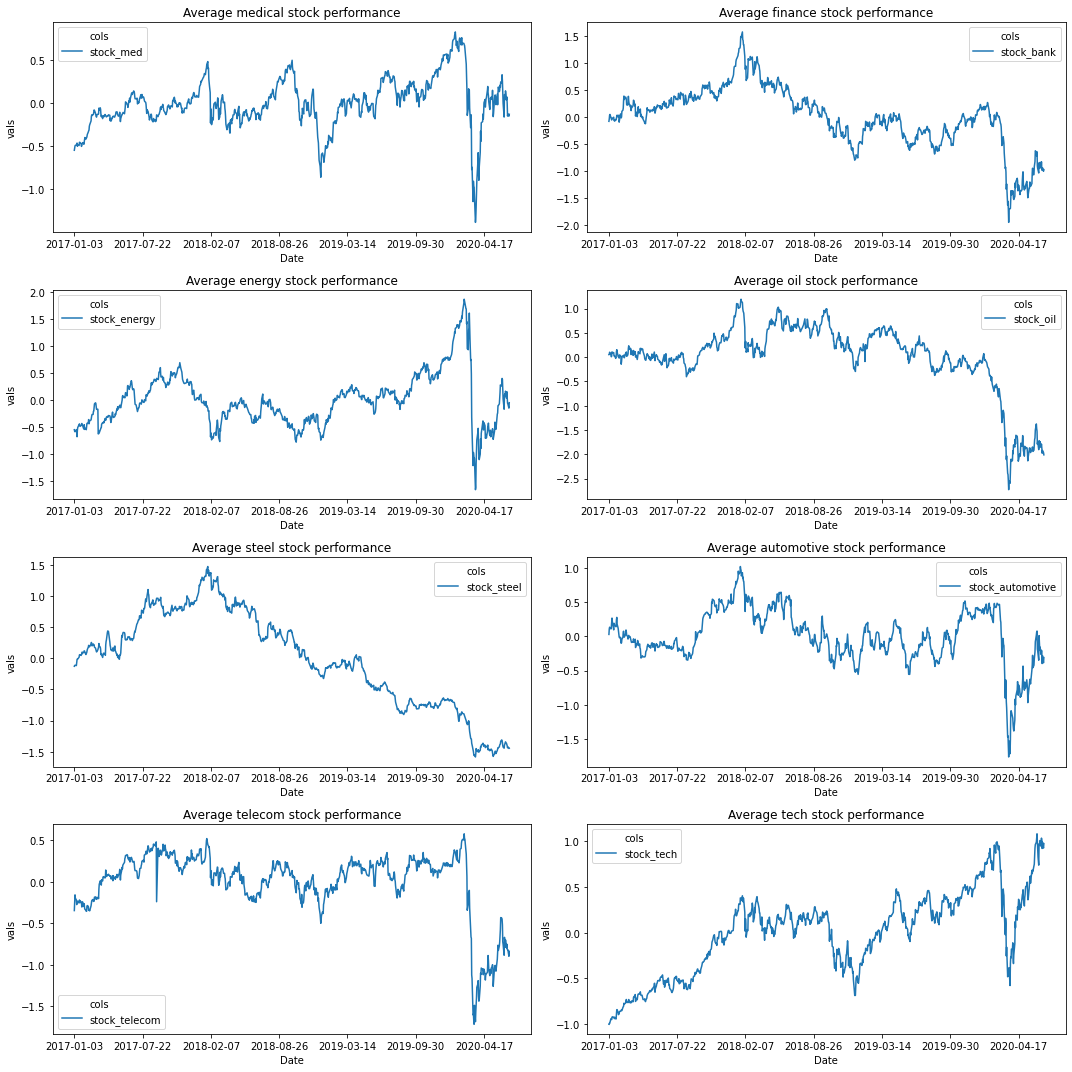

In [15]:

for domain in sector_tuple_list:
    for code in domain.stock_code_list:
        if code in df.keys():
            df[code].interpolate(inplace=True)
    df[domain.df_column_name] = sum([(df[stock] - df[stock].mean())/df[stock].std() for stock in domain.stock_code_list
                                    if stock in df.keys()])/len(domain.stock_code_list)
    df[domain.df_column_name].replace(min(df[domain.df_column_name]), np.nan, inplace=True)
    df[domain.df_column_name].interpolate(method='polynomial', order=3, inplace=True)

med_df = df.melt('Date', value_vars= ['stock_med'], 
                   var_name='cols',  value_name='vals')
bank_df = df.melt('Date', value_vars= ['stock_bank'], 
                   var_name='cols',  value_name='vals')
energy_df = df.melt('Date', value_vars= ['stock_energy'], 
                   var_name='cols',  value_name='vals')
oil_df = df.melt('Date', value_vars= ['stock_oil'], 
                   var_name='cols',  value_name='vals')
steel_df = df.melt('Date', value_vars= ['stock_steel'], 
                   var_name='cols',  value_name='vals')
automotive_df = df.melt('Date', value_vars= ['stock_automotive'], 
                   var_name='cols',  value_name='vals')
telecom_df = df.melt('Date', value_vars= ['stock_telecom'], 
                   var_name='cols',  value_name='vals')
tech_df = df.melt('Date', value_vars= ['stock_tech'], 
                   var_name='cols',  value_name='vals')

fig, axes = plt.subplots(4, 2, sharex=False, sharey=False, figsize=(15,15))
g0 = sns.lineplot(x="Date", y="vals", hue='cols', data=med_df, ax=axes[0,0])
g1 = sns.lineplot(x="Date", y="vals", hue='cols', data=bank_df, ax=axes[0,1])
g2 = sns.lineplot(x="Date", y="vals", hue='cols', data=energy_df, ax=axes[1,0])
g3 = sns.lineplot(x="Date", y="vals", hue='cols', data=oil_df, ax=axes[1,1])
g4 = sns.lineplot(x="Date", y="vals", hue='cols', data=steel_df, ax=axes[2,0])
g5 = sns.lineplot(x="Date", y="vals", hue='cols', data=automotive_df, ax=axes[2,1])
g6 = sns.lineplot(x="Date", y="vals", hue='cols', data=telecom_df, ax=axes[3,0])
g7 = sns.lineplot(x="Date", y="vals", hue='cols', data=tech_df, ax=axes[3,1])

g0.set_xticks(np.arange(0,len(med_df),200))
g0.set_title('Average medical stock performance')
g1.set_xticks(np.arange(0,len(med_df),200))
g1.set_title('Average finance stock performance')
g2.set_xticks(np.arange(0,len(med_df),200))
g2.set_title('Average energy stock performance')
g3.set_xticks(np.arange(0,len(med_df),200))
g3.set_title('Average oil stock performance')
g4.set_xticks(np.arange(0,len(med_df),200))
g4.set_title('Average steel stock performance')
g5.set_xticks(np.arange(0,len(med_df),200))
g5.set_title('Average automotive stock performance')
g6.set_xticks(np.arange(0,len(med_df),200))
g6.set_title('Average telecom stock performance')
g7.set_xticks(np.arange(0,len(med_df),200))
g7.set_title('Average tech stock performance')

g0.plot()
g1.plot()
g2.plot()
g3.plot()
g4.plot()
g5.plot()
g6.plot()
g7.plot()

fig.tight_layout()
plt.show()

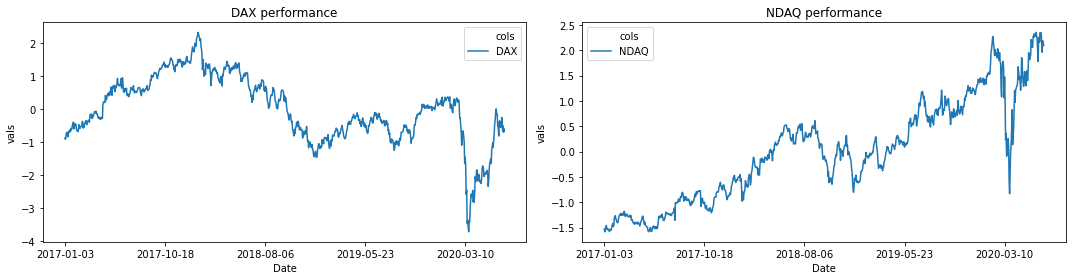

In [16]:
# Inspect and normalize index data.
index_codes = ['DAX', 'NDAQ']
for code in index_codes:
    df[code] = (df[code] - df[code].mean())/df[code].std()

dax_df = df.melt('Date', value_vars= ['DAX'], 
                   var_name='cols',  value_name='vals')
ndaq_df = df.melt('Date', value_vars= ['NDAQ'], 
                   var_name='cols',  value_name='vals')

fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,4))
g0 = sns.lineplot(x="Date", y="vals", hue='cols', data=dax_df, ax=axes[0])
g1 = sns.lineplot(x="Date", y="vals", hue='cols', data=ndaq_df, ax=axes[1])

g0.set_xticks(np.arange(0,801,200))
g0.set_title('DAX performance')
g1.set_xticks(np.arange(0,801,200))
g1.set_title('NDAQ performance')

g0.plot()
g1.plot()

fig.tight_layout()
plt.show()

In [17]:
for domain in sector_tuple_list:
    for code in domain.stock_code_list:
        if code in df.keys():
            df.drop(code, axis=1, inplace=True)
    
for code in index_codes:
    if code in df.keys():
        df.drop(code, axis=1, inplace=True)
        
for code in ['TDXP', 'INDU', 'NKY']:
    if code in df.keys():
        df.drop(code, axis=1, inplace=True)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1277 entries, 0 to 1276
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         1277 non-null   object 
 1   deaths                       1277 non-null   float64
 2   confirmed                    1277 non-null   float64
 3   recovered                    1277 non-null   float64
 4   active                       1277 non-null   float64
 5   new_confirmed                1277 non-null   float64
 6   new_recovered                1277 non-null   float64
 7   new_deaths                   1277 non-null   float64
 8   bitrate                      1096 non-null   float64
 9   Weekly_average_change_views  906 non-null    float64
 10  Weekly_average_views         906 non-null    float64
 11  Users                        936 non-null    float64
 12  In-Game                      936 non-null    float64
 13  av_conc_viewers   

In [18]:
# Unify naming scheme.
df.rename(columns={'deaths': 'corona_deaths', 'confirmed': 'corona_confirmed', 'recovered': 'corona_recovered', 
                   'active': 'corona_active', 'new_recovered': 'corona_new_recovered', 'new_deaths': 'corona_new_deaths',
                   'bitrate': 'ix_bitrate', 'Weekly_average_change_views': 'youtube_viewchange', 
                   'Weekly_average_views': 'youtube_views', 'Users': 'steam_users', 'In-Game': 'steam_ingame', 
                   'av_conc_viewers': 'twitch_views', 'av_conc_channels': 'twitch_channels', 'time_watched': 'twitch_viewtime', 
                   'active_streamers': 'twitch_streams', 'PS': 'ps_users'}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1277 entries, 0 to 1276
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1277 non-null   object 
 1   corona_deaths         1277 non-null   float64
 2   corona_confirmed      1277 non-null   float64
 3   corona_recovered      1277 non-null   float64
 4   corona_active         1277 non-null   float64
 5   new_confirmed         1277 non-null   float64
 6   corona_new_recovered  1277 non-null   float64
 7   corona_new_deaths     1277 non-null   float64
 8   ix_bitrate            1096 non-null   float64
 9   youtube_viewchange    906 non-null    float64
 10  youtube_views         906 non-null    float64
 11  steam_users           936 non-null    float64
 12  steam_ingame          936 non-null    float64
 13  twitch_views          1248 non-null   float64
 14  twitch_channels       1248 non-null   float64
 15  twitch_viewtime      

In [19]:
# Rearrange column order to make scaling easy. 
cols = df.columns.tolist()
cols = cols[8:26] + cols[1:7] + [cols[0]]
df = df[cols]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1277 entries, 0 to 1276
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ix_bitrate            1096 non-null   float64
 1   youtube_viewchange    906 non-null    float64
 2   youtube_views         906 non-null    float64
 3   steam_users           936 non-null    float64
 4   steam_ingame          936 non-null    float64
 5   twitch_views          1248 non-null   float64
 6   twitch_channels       1248 non-null   float64
 7   twitch_viewtime       1248 non-null   float64
 8   twitch_streams        1248 non-null   float64
 9   ps_users              1217 non-null   float64
 10  stock_med             1275 non-null   float64
 11  stock_bank            1275 non-null   float64
 12  stock_energy          1275 non-null   float64
 13  stock_oil             1275 non-null   float64
 14  stock_steel           1275 non-null   float64
 15  stock_automotive     

In [20]:
# Scaler for the whole dataset. Only operates on the dates before Covid to avoid test set bias.

# Custom split into pre-Corona data and Corona data.
pre_corona_df = df.truncate(after=end_index)
corona_df = df.truncate(before=end_index)

scaler = StandardScaler()
ct = ColumnTransformer([('scaler', scaler, np.arange(0,24))],remainder='passthrough')
scaled_pre_corona_data = ct.fit_transform(pre_corona_df)
scaled_corona_data = ct.transform(corona_df)

scaled_pre_corona_df = pd.DataFrame(columns=pre_corona_df.columns, data=scaled_pre_corona_data.copy())
scaled_corona_df = pd.DataFrame(columns=corona_df.columns, data=scaled_corona_data.copy())

for key in corona_df.keys():
    if not key == 'Date':
        scaled_pre_corona_df[key] = pd.to_numeric(scaled_pre_corona_df[key], downcast="float")
        scaled_corona_df[key] = pd.to_numeric(scaled_corona_df[key], downcast="float")

In [37]:
#pre_corona_df.head
import joblib 

for column in pre_corona_df:
    print( root.joinpath('res', 'pipeline', f'scaler_{column}.save'))
    st_scaler = StandardScaler()
    fu = pre_corona_df[column]
    st_scaler.fit(pre_corona_df[column].values.reshape(-1,1))
    
    # Save the scaler.
    joblib.dump(st_scaler, root.joinpath('res', 'pipeline', f'scaler_{column}.save'))
    print('Data sets saved.')

c:\Users\AronE\Documents\Python\ami\group11\res\pipeline\scaler_ix_bitrate.save
[-0.02643268]
Data sets saved.
c:\Users\AronE\Documents\Python\ami\group11\res\pipeline\scaler_youtube_viewchange.save
[59230031.25371312]
Data sets saved.
c:\Users\AronE\Documents\Python\ami\group11\res\pipeline\scaler_youtube_views.save
[40087665.48514078]
Data sets saved.
c:\Users\AronE\Documents\Python\ami\group11\res\pipeline\scaler_steam_users.save
[15346176.44113842]
Data sets saved.
c:\Users\AronE\Documents\Python\ami\group11\res\pipeline\scaler_steam_ingame.save
[4715022.47477361]
Data sets saved.
c:\Users\AronE\Documents\Python\ami\group11\res\pipeline\scaler_twitch_views.save
[1032199.57814711]
Data sets saved.
c:\Users\AronE\Documents\Python\ami\group11\res\pipeline\scaler_twitch_channels.save
[38806.31615802]
Data sets saved.
c:\Users\AronE\Documents\Python\ami\group11\res\pipeline\scaler_twitch_viewtime.save
[7.49070564e+08]
Data sets saved.
c:\Users\AronE\Documents\Python\ami\group11\res\pipe

ValueError: could not convert string to float: '2017-01-01'

In [29]:
data = [[0, 0], [0, 0], [1, 1], [1, 1]]
data

[[0, 0], [0, 0], [1, 1], [1, 1]]

<ipython-input-42-052dd1adbb00>:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(scaled_pre_corona_df,ax=ax)
C:\Users\amacati\.conda\envs\ami\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\amacati\.conda\envs\ami\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\amacati\.conda\envs\ami\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


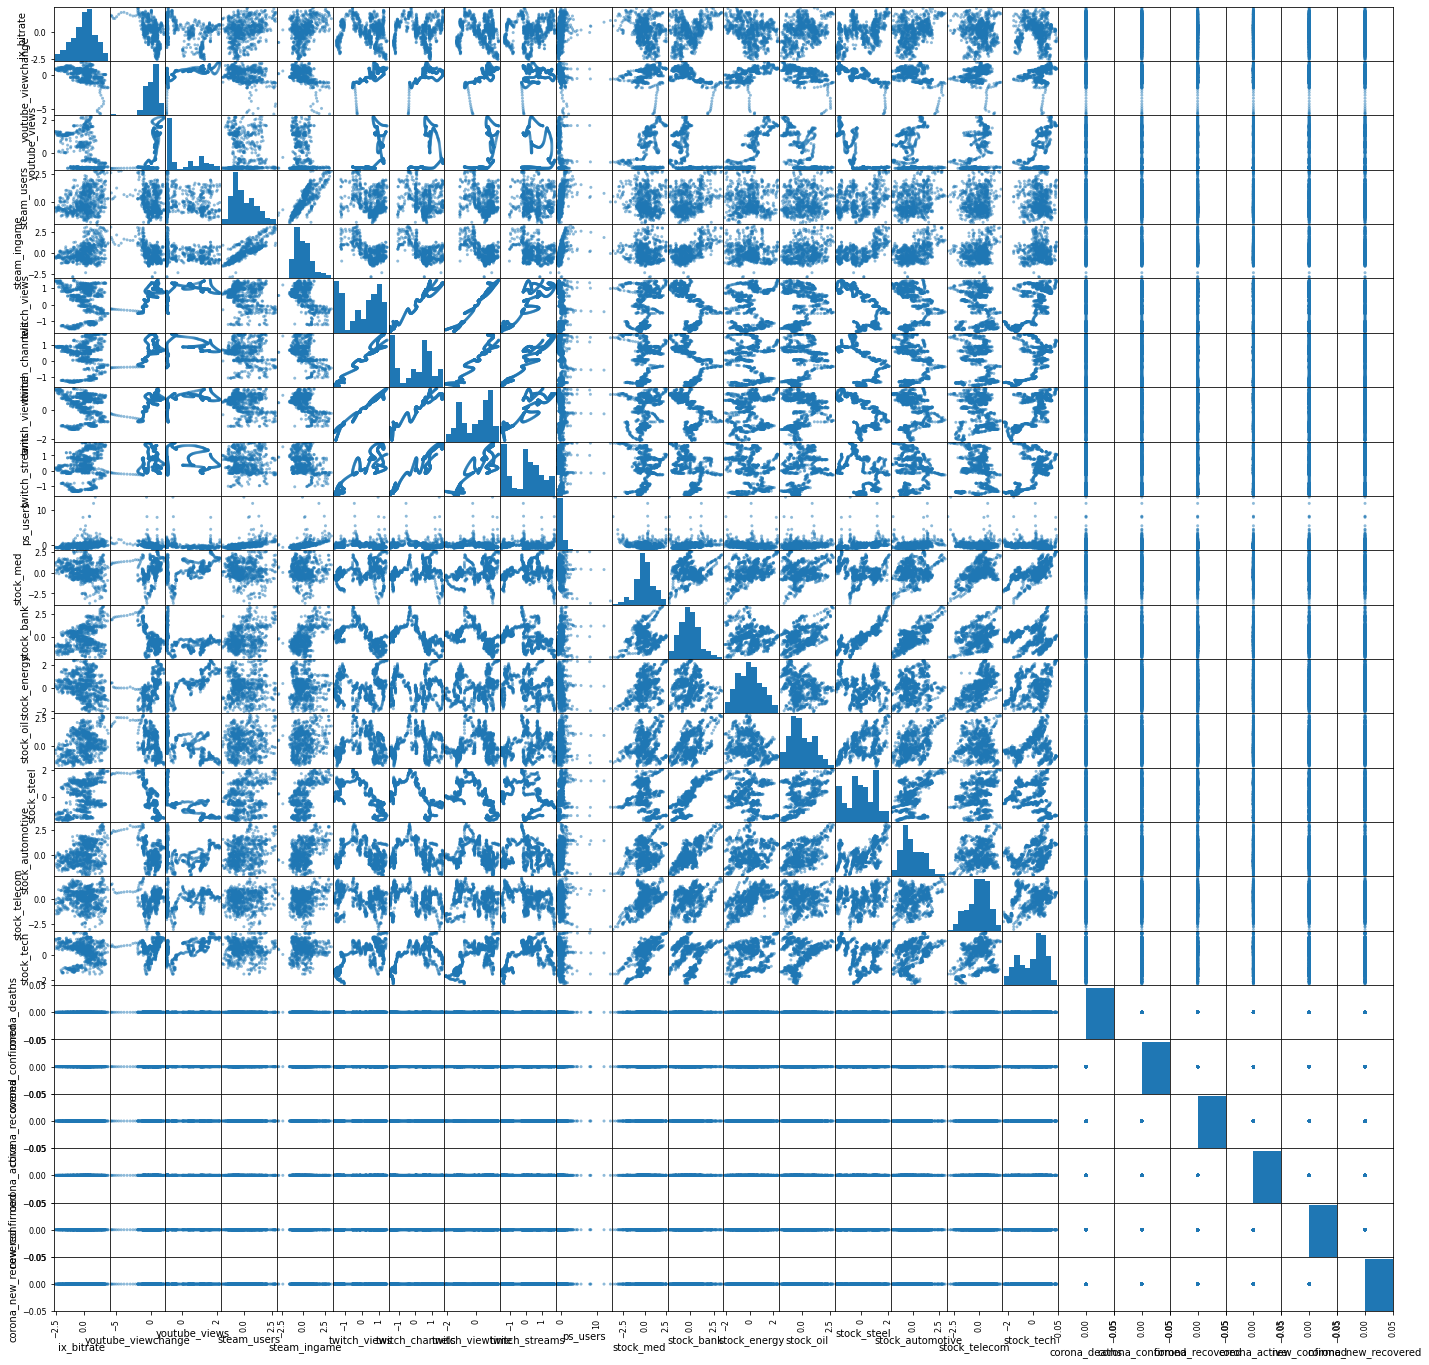

In [42]:
# All Corona data is 0 pre Covid, therefore plots are singular.

fig = plt.figure(figsize=(24,24))
ax = fig.add_axes([0,0,1,1])

pd.plotting.scatter_matrix(scaled_pre_corona_df,ax=ax)
plt.show()

<ipython-input-43-2479f55aa322>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(scaled_corona_df,ax=ax)


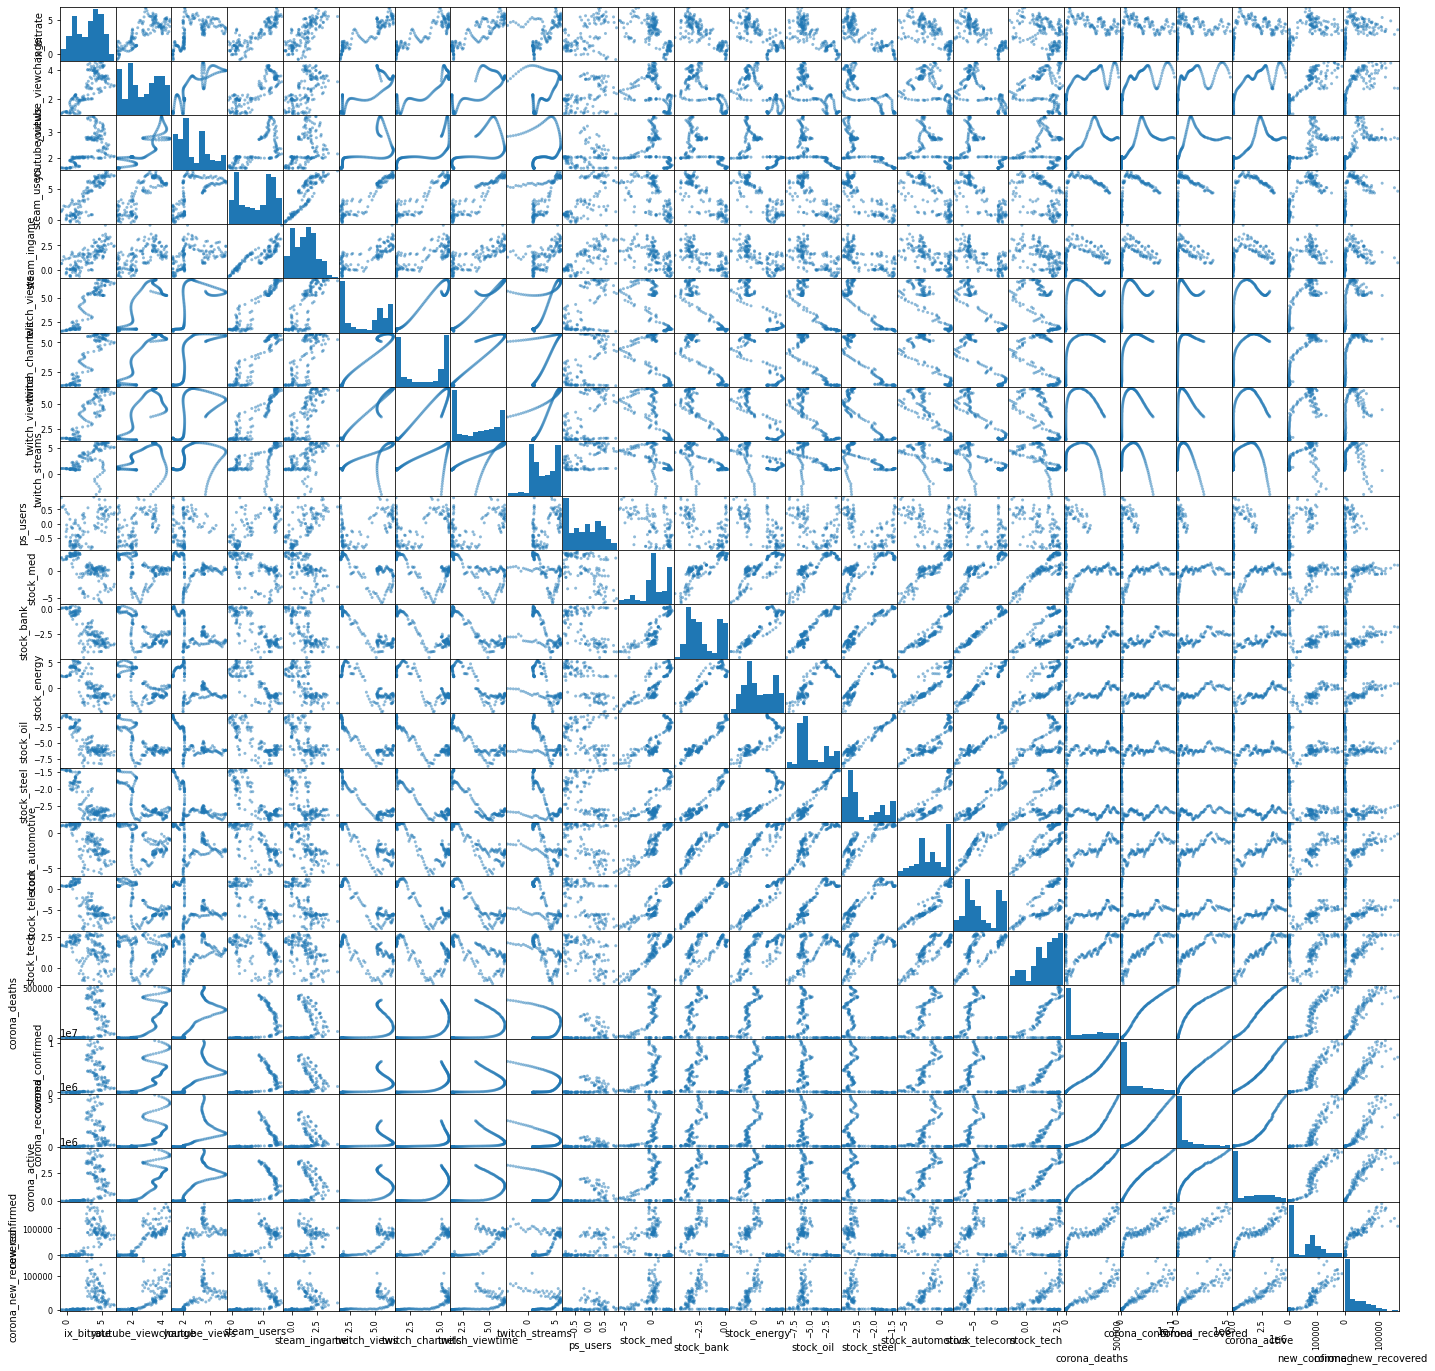

In [43]:
fig = plt.figure(figsize=(24,24))
ax = fig.add_axes([0,0,1,1])

pd.plotting.scatter_matrix(scaled_corona_df,ax=ax)
plt.show()

ix_bitrate


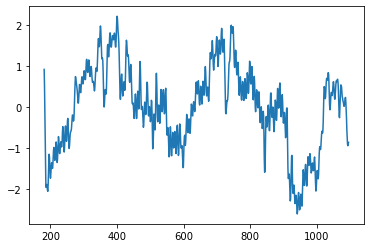

youtube_viewchange


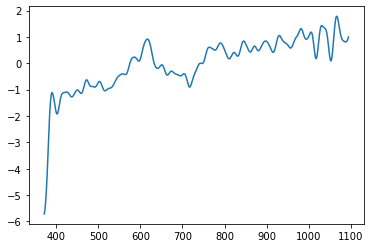

youtube_views


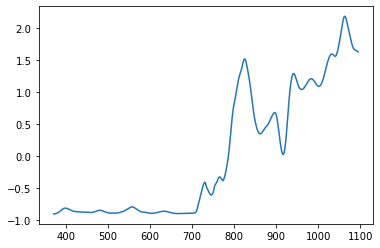

steam_users


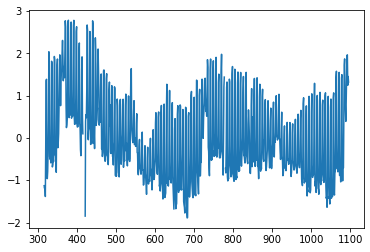

steam_ingame


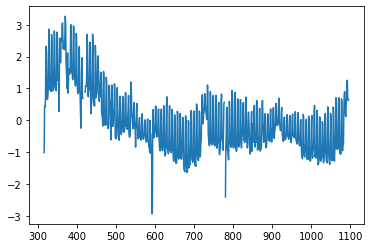

twitch_views


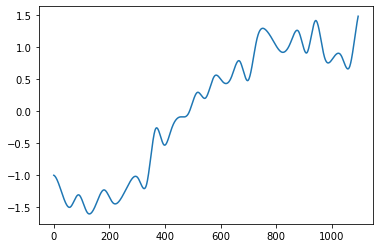

twitch_channels


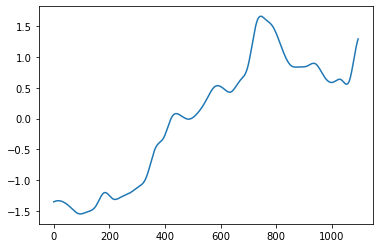

twitch_viewtime


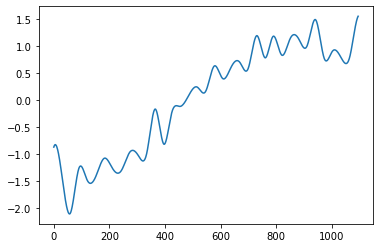

twitch_streams


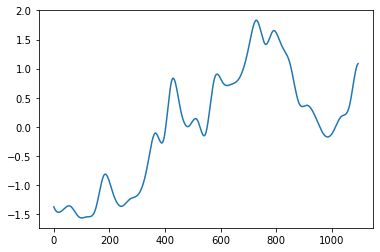

ps_users


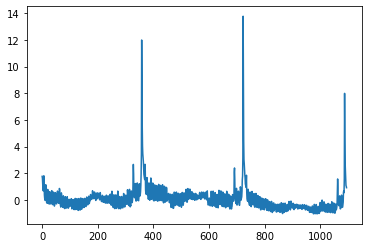

stock_med


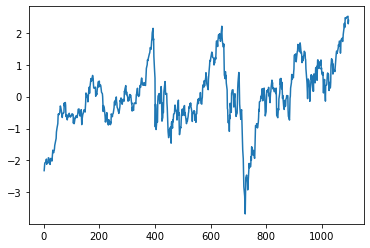

stock_bank


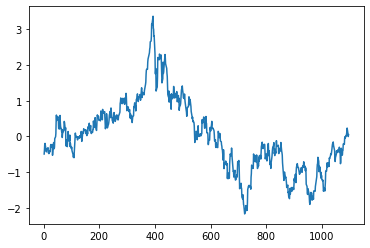

stock_energy


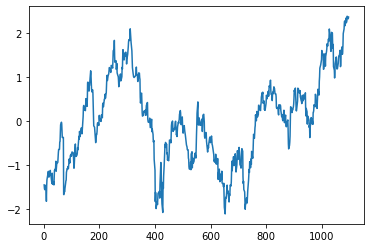

stock_oil


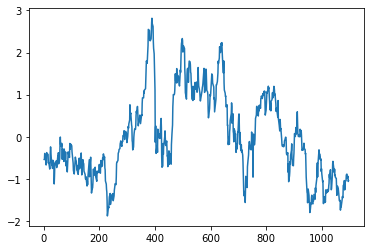

stock_steel


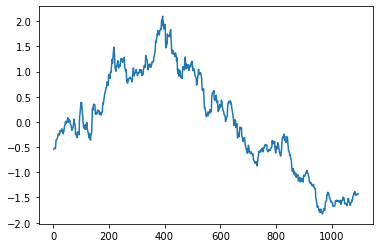

stock_automotive


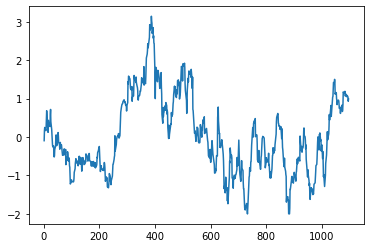

stock_telecom


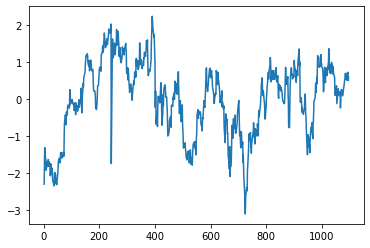

stock_tech


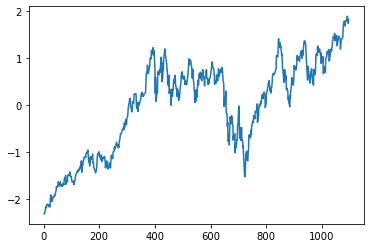

corona_deaths


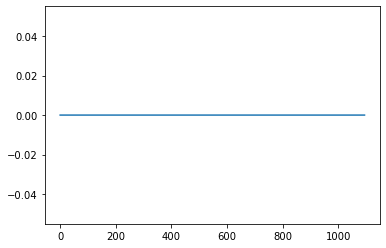

corona_confirmed


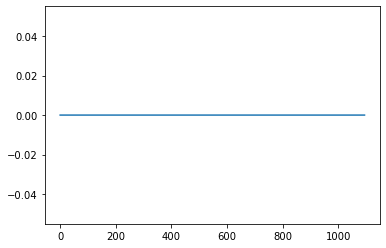

corona_recovered


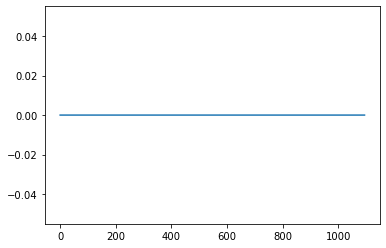

corona_active


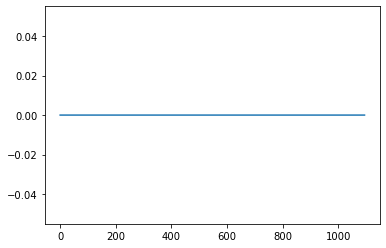

new_confirmed


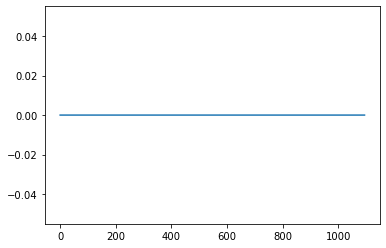

corona_new_recovered


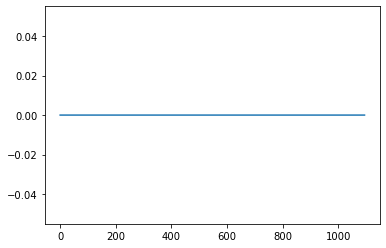

Date


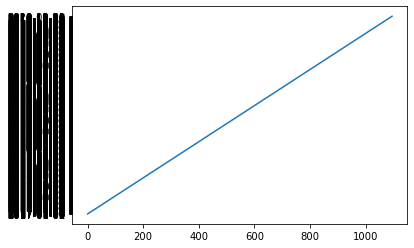

In [44]:
for key in scaled_pre_corona_df.keys():
    print(key)
    plt.plot(scaled_pre_corona_df[key])
    plt.show()

In [46]:
import joblib 

# Save the dataframes.
scaled_pre_corona_df_path = root.joinpath('res', 'pipeline', 'scaled_pre_corona_df.csv')
scaled_corona_df_path = root.joinpath('res', 'pipeline', 'scaled_corona_df.csv')

scaled_pre_corona_df.to_csv(scaled_pre_corona_df_path)
scaled_corona_df.to_csv(scaled_corona_df_path)

# Save the scaler.
joblib.dump(scaler, root.joinpath('res', 'pipeline', 'scaler.save'))

['C:\\Users\\amacati\\Desktop\\Uni\\Semester 2\\Applied Machine Intelligence\\group11\\res\\pipeline\\scaler.save']